<a href="https://colab.research.google.com/github/Suee18/Forecasting_Flights-DataScience/blob/main/notebooks/preprocessing/3Mflights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3M dataset - Data Preprocessing

 cleansing 3M flight records for delay prediction modeling.

## Contents
1. [Data Loading](#loading)
2. [Handling cancelled flihgts](#cancelled)
3. [Save Processed Dataset](#save)

## 1. Data Loading <a id='loading'></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("patrickzel/flight-delay-and-cancellation-dataset-2019-2023")

print("Path to dataset files:", path)


100%|██████████| 140M/140M [00:02<00:00, 68.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023/versions/7


In [2]:
!git clone https://github.com/Suee18/Forecasting_Flights-DataScience

Cloning into 'Forecasting_Flights-DataScience'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 78 (delta 18), reused 64 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (78/78), 3.60 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [3]:
import os
os.chdir("Forecasting_Flights-DataScience")  # Change to your repo folder name

In [4]:
import sys
sys.path.append("/content/Forecasting_Flights-DataScience")
sys.path.append("/content/Forecasting_Flights-DataScience/src")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')
sns.set(style="whitegrid")

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.append(PROJECT_ROOT)
from src.data import loader, processor
from src.visualization import exploratory_viz

In [6]:
raw_file_path = os.path.join(PROJECT_ROOT, 'data', 'raw', 'flights_sample_3m.csv')
processed_dir = os.path.join(PROJECT_ROOT, 'data', 'processed')
os.makedirs(processed_dir, exist_ok=True)

print(f"Input data file: {raw_file_path}")
print(f"Processed data directory: {processed_dir}")

Input data file: /data/raw/flights_sample_3m.csv
Processed data directory: /data/processed


In [8]:
from pathlib import Path

# Find the CSV file automatically
kaggle_dir = Path("/root/.cache/kagglehub/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023/versions/7")
csv_files = list(kaggle_dir.glob("*.csv"))

if not csv_files:
    raise FileNotFoundError("No CSV file found in Kaggle download directory")

raw_file_path = str(csv_files[0])
print(f"Using data file: {raw_file_path}")

# Now process the chunks
first_chunk = next(process_data_in_chunks(raw_file_path, chunksize=5))
first_chunk

Using data file: /root/.cache/kagglehub/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023/versions/7/flights_sample_3m.csv


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


## 2. Handling Cancelled Flights <a id='cancelled'></a>

As we're focusing on predicting delays for flights that actually operated, we'll separate cancelled flights from our analysis dataset. Cancelled flights represent a different phenomenon and would confuse our delay prediction models.

In [9]:
# First, let's analyze how many flights were cancelled
def analyze_cancellations(file_path, chunksize=100000):
    cancelled_count = 0
    total_count = 0
    cancellation_codes = {}

    # Process in chunks to handle the large dataset
    for i, chunk in enumerate(pd.read_csv(file_path, chunksize=chunksize)):
        total_count += len(chunk)

        # Count cancelled flights
        cancelled_in_chunk = chunk[chunk['CANCELLED'] == 1.0]
        cancelled_count += len(cancelled_in_chunk)

        # Track cancellation reasons
        code_counts = cancelled_in_chunk['CANCELLATION_CODE'].value_counts()
        for code, count in code_counts.items():
            if code in cancellation_codes:
                cancellation_codes[code] += count
            else:
                cancellation_codes[code] = count

        # Print progress
        if (i+1) % 10 == 0:
            print(f"Processed {(i+1)*chunksize:,} rows...")

    # Calculate percentage
    cancelled_pct = (cancelled_count / total_count) * 100 if total_count > 0 else 0

    # Create a summary dictionary
    summary = {
        'total_flights': total_count,
        'cancelled_flights': cancelled_count,
        'cancelled_percentage': cancelled_pct,
        'cancellation_codes': cancellation_codes
    }

    return summary

# Run the analysis
cancellation_summary = analyze_cancellations(raw_file_path)

# Display the results
print(f"Total Flights: {cancellation_summary['total_flights']:,}")
print(f"Cancelled Flights: {cancellation_summary['cancelled_flights']:,} ({cancellation_summary['cancelled_percentage']:.2f}%)")
print("\nCancellation Codes:")
for code, count in cancellation_summary['cancellation_codes'].items():
    print(f"  {code}: {count:,} flights")

# Explanation of cancellation codes
code_meanings = {
    'A': 'Carrier',
    'B': 'Weather',
    'C': 'National Air System',
    'D': 'Security'
}

print("\nCancellation Code Meanings:")
for code, meaning in code_meanings.items():
    print(f"  {code}: {meaning}")

Processed 1,000,000 rows...
Processed 2,000,000 rows...
Processed 3,000,000 rows...
Total Flights: 3,000,000
Cancelled Flights: 79,140 (2.64%)

Cancellation Codes:
  B: 28,772 flights
  D: 24,417 flights
  A: 19,476 flights
  C: 6,475 flights

Cancellation Code Meanings:
  A: Carrier
  B: Weather
  C: National Air System
  D: Security


In [10]:
# Function to filter out cancelled flights and save operational flights
def filter_operational_flights(input_path, output_path, chunksize=100000):
    """
    Filter the dataset to include only operational flights (not cancelled)
    and save it to a new CSV file.

    Args:
        input_path: Path to the input CSV file
        output_path: Path to save the filtered CSV file
        chunksize: Number of rows to process at a time
    """
    # Track statistics
    total_rows = 0
    operational_rows = 0

    # Process the first chunk to get the header
    first_chunk = True

    # Process in chunks
    for i, chunk in enumerate(pd.read_csv(input_path, chunksize=chunksize)):
        # Update counts
        total_rows += len(chunk)

        # Filter out cancelled flights
        operational_chunk = chunk[chunk['CANCELLED'] != 1.0]
        operational_rows += len(operational_chunk)

        # Save the chunk (append mode after first chunk)
        if first_chunk:
            operational_chunk.to_csv(output_path, index=False)
            first_chunk = False
        else:
            operational_chunk.to_csv(output_path, mode='a', header=False, index=False)

        # Print progress
        if (i+1) % 5 == 0:
            print(f"Processed {(i+1)*chunksize:,} rows...")

    # Return statistics
    return {
        'total_rows': total_rows,
        'operational_rows': operational_rows,
        'filtered_rows': total_rows - operational_rows,
        'filtered_percentage': ((total_rows - operational_rows) / total_rows) * 100 if total_rows > 0 else 0
    }

operational_flights_path = os.path.join(processed_dir, 'operational_flights.csv')

# Run the filtering process
print("Filtering out cancelled flights...")
filter_stats = filter_operational_flights(raw_file_path, operational_flights_path)

# Display the results
print("\nFiltering complete!")
print(f"Total rows processed: {filter_stats['total_rows']:,}")
print(f"Operational flights: {filter_stats['operational_rows']:,}")
print(f"Cancelled flights removed: {filter_stats['filtered_rows']:,} ({filter_stats['filtered_percentage']:.2f}%)")
print(f"\nOperational flights saved to: {operational_flights_path}")

Filtering out cancelled flights...
Processed 500,000 rows...
Processed 1,000,000 rows...
Processed 1,500,000 rows...
Processed 2,000,000 rows...
Processed 2,500,000 rows...
Processed 3,000,000 rows...

Filtering complete!
Total rows processed: 3,000,000
Operational flights: 2,920,860
Cancelled flights removed: 79,140 (2.64%)

Operational flights saved to: /data/processed/operational_flights.csv


# handling missing values


Figure saved to /content/reports/figures/3m/missing_values.png


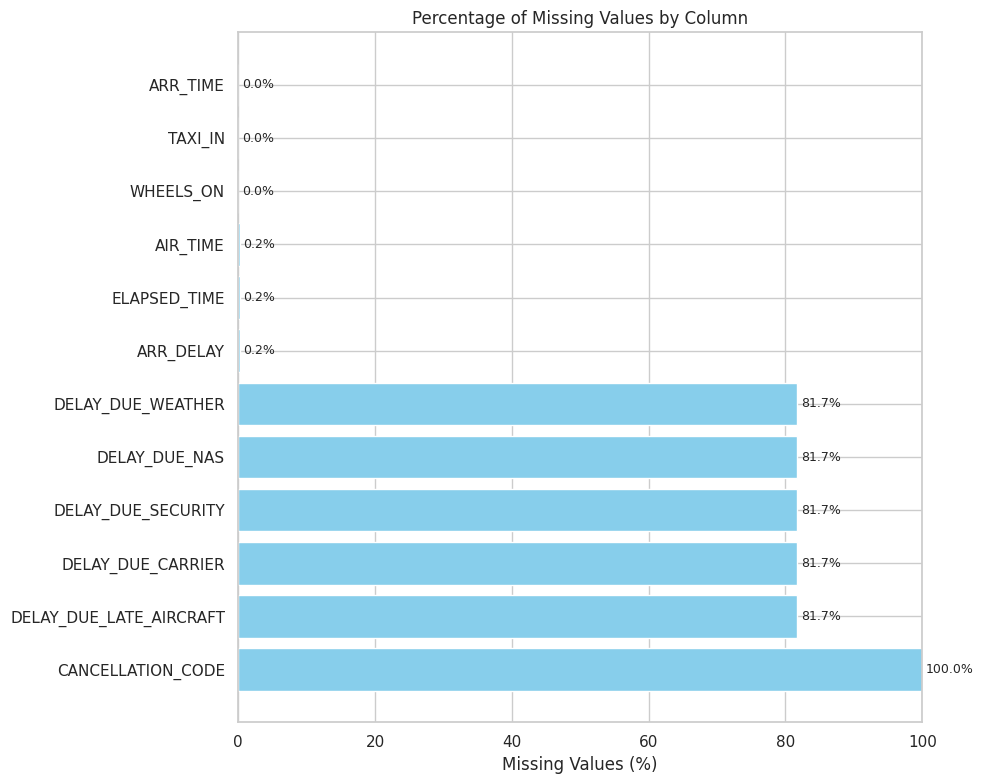

In [12]:
missing_data = processor.analyze_missing_values(operational_flights_path)

# Plot missing values
exploratory_viz.plot_missing_values(missing_data)

In [17]:
# List of columns to drop
columns_to_drop = [
    'DELAY_DUE_WEATHER',
    'DELAY_DUE_NAS',
    'CANCELLATION_CODE',
    'DELAY_DUE_SECURITY',
    'DELAY_DUE_CARRIER',
    'DELAY_DUE_LATE_AIRCRAFT'
]

# Function to process data and drop columns in chunks
def process_and_clean_data(file_path, output_path, chunksize=100000):
    """
    Process the dataset in chunks, dropping specified columns,
    and save the cleaned data to a new CSV file.
    """
    first_chunk = True

    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        # Drop the specified columns
        cleaned_chunk = chunk.drop(columns=columns_to_drop, errors='ignore')

        # Save to CSV (write header only for first chunk)
        if first_chunk:
            cleaned_chunk.to_csv(output_path, index=False)
            first_chunk = False
        else:
            cleaned_chunk.to_csv(output_path, mode='a', header=False, index=False)

    print(f"Cleaned data saved to: {output_path}")

# Paths (using the corrected raw_file_path from earlier)
cleaned_file_path = os.path.join(processed_dir, 'cleaned_flights.csv')

# Process and clean the data
process_and_clean_data(operational_flights_path, cleaned_file_path)

# Verify the first few rows of cleaned data
pd.read_csv(cleaned_file_path, nrows=5).head()

Cleaned data saved to: /data/processed/cleaned_flights.csv


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,4.0,1501,1447.0,-14.0,0.0,0.0,186.0,176.0,153.0,1065.0
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,38.0,2315,2310.0,-5.0,0.0,0.0,235.0,236.0,189.0,1399.0
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,5.0,1252,1252.0,0.0,0.0,0.0,118.0,112.0,87.0,680.0
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,9.0,1829,1853.0,24.0,0.0,0.0,260.0,285.0,249.0,1589.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,14.0,2041,2040.0,-1.0,0.0,0.0,181.0,182.0,153.0,985.0


In [18]:
df = pd.read_csv(cleaned_file_path)

df['CANCELLED'].head(20)

,CANCELLED
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [19]:
# Display unique values in CANCELLED column
unique_cancelled = df['CANCELLED'].unique()
print("Unique values in CANCELLED column:", unique_cancelled)

# For more detailed breakdown
print("\nValue counts:")
print(df['CANCELLED'].value_counts())

Unique values in CANCELLED column: [0.]

Value counts:
CANCELLED
0.0    2920860
Name: count, dtype: int64


In [20]:
df.drop(columns=['CANCELLED'], inplace=True)

droping arrival delay to not get false accuracy in departure delay


In [22]:
df.drop(columns=['ARR_DELAY'], inplace=True)